<a href="https://colab.research.google.com/github/duypham01/PDENet/blob/main/InverseDiffEq_find_C_27_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import time
import json
import tensorflow.keras as keras
import tensorflow_probability as tfp

In [ ]:
np.exp(1)

2.718281828459045

In [ ]:
def u_exact(x,t):
    return np.exp(-np.pi**2*t)*np.sin(np.pi*x)
def generateObservation(h, x_arr, delta_t, t_0, n_t):
    x = []
    tmp = x_arr[0]
    while tmp <= x_arr[1]:
        x.append(tmp)
        tmp = tmp + h
    U = []
    t = []
    for i in range(n_t):
        t_tmp = t_0 + i*delta_t
        t.append(t_tmp)
        tmp = []
        for el in x:
            tmp.append(u_exact(el, t_tmp))
        U.append(tmp)
    return U, x, t

In [ ]:
U, x, t = generateObservation(0.002, [-1,1], 0.001, 0.1, 2)

In [ ]:
x

In [ ]:
len(U[0])

1000

In [ ]:
# BUILD NETWORK

# dimension of input and output
in_dim = 1
out_dim = 1

# number of neurons on each layer
nn = [16, 16, 16, 16]

# input layer
inputs = keras.Input(shape=(in_dim,), name='points')

# hidden layers
hidden = keras.layers.Dense(nn[0], activation='tanh', name='hidden_1')(inputs)
for i in range(len(nn)-1):
    hidden = keras.layers.Dense(nn[i+1], activation='tanh', name='hidden_' + str(i+2))(hidden)

# output layer
outputs = keras.layers.Dense(out_dim, activation='linear', name="u")(hidden)

# create network
PDEmodel = keras.Model(inputs=inputs, outputs=outputs, name='heat')

# show network details
PDEmodel.summary()

Model: "heat"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 points (InputLayer)         [(None, 1)]               0         
                                                                 
 hidden_1 (Dense)            (None, 16)                32        
                                                                 
 hidden_2 (Dense)            (None, 16)                272       
                                                                 
 hidden_3 (Dense)            (None, 16)                272       
                                                                 
 hidden_4 (Dense)            (None, 16)                272       
                                                                 
 u (Dense)                   (None, 1)                 17        
                                                                 
Total params: 865
Trainable params: 865
Non-trainable params: 

In [ ]:
def fun_f1(x,t):
    return np.pi**2*(1+np.exp(-(x-0.5)**2))*np.exp(-np.pi**2*t)*np.sin(np.pi*x)-np.pi**2*np.exp(-np.pi**2*t)*np.sin(np.pi*x)

def fun_f(x,t):
    return np.pi**2*(1+tf.math.exp(-(x-0.5)**2))*tf.math.exp(-np.pi**2*t)*tf.math.sin(np.pi*x)-np.pi**2*tf.math.exp(-np.pi**2*t)*tf.math.sin(np.pi*x)
# return 1D weights
def get_weights():
    w = []
    for layer in PDEmodel.layers[1:]:
        weights_biases = layer.get_weights()
        weights = weights_biases[0].flatten()
        biases = weights_biases[1]
        w.extend(weights)
        w.extend(biases)
    return w

# get size of weights in each model's layer
sizes_w = []
sizes_b = []
for layer in PDEmodel.layers[1:]:
    weights_biases = layer.get_weights()
    sizes_w.append(weights_biases[0].flatten().size)
    sizes_b.append(weights_biases[1].size)

# convert 1D weights to multi dimension weights in each model's layer
def set_weights(w):
    for i, layer in enumerate(PDEmodel.layers[1:]):
        start_weights = sum(sizes_w[:i]) + sum(sizes_b[:i])
        end_weights = sum(sizes_w[:i+1]) + sum(sizes_b[:i])
        weights = w[start_weights:end_weights]
        w_div = int(sizes_w[i] / sizes_b[i])
        weights = tf.reshape(weights, [w_div, sizes_b[i]])
        biases = w[end_weights:end_weights + sizes_b[i]]
        weights_biases = [weights, biases]
        layer.set_weights(weights_biases)
def train(U, x, t, delta_t, h, epochs, optimizer):
    losses_hist = []
    # x_in = tf.convert_to_tensor(x, dtype=tf.float32)

    if (optimizer == 'adam'):
        optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999)
        for epoch in range(epochs):
            start_epoch = time.time()
            loss = [0]
            with tf.GradientTape() as tape:
                loss = 0
                for i in range(len(t)-1):
                    for j in range(1,len(x)-1):
                        x_in = tf.reshape(tf.convert_to_tensor(x[j], dtype=tf.float32), [1])
                        t_in1 = tf.reshape(tf.convert_to_tensor(t[i+1], dtype=tf.float32), [1])
                        t_in = tf.reshape(tf.convert_to_tensor(t[i], dtype=tf.float32), [1])
                        loss = loss + tf.math.square(1/delta_t*(U[i+1][j]-U[i][j]) - PDEmodel(x_in)[0][0]/(2*h**2)*(U[i+1][j+1]+U[i+1][j-1]-2*U[i+1][j]) \
                        - PDEmodel(x_in)[0][0]/(2*h**2)*(U[i][j+1]+U[i][j-1]-2*U[i][j])-0.5*(fun_f(x_in,t_in)[0]+fun_f(x_in,t_in1)[0]))
            grads = tape.gradient(loss, PDEmodel.weights)
            optimizer.apply_gradients(zip(grads, PDEmodel.weights))
            print("[%4s] loss = %12.8f \t %4.3fs" % (epoch, loss, time.time() - start_epoch))
            losses_hist.append(loss.numpy())
    if (optimizer == 'l-bfgs'):
        def function_factory(x):
            def loss_grad(weights):
                start_epoch = time.time()
                with tf.GradientTape() as tape:
                    loss = 0
                    for i in range(len(t)-1):
                        for j in range(1,len(x)-1):
                            x_in = tf.reshape(tf.convert_to_tensor(x[j], dtype=tf.float32), [1])
                            t_in1 = tf.reshape(tf.convert_to_tensor(t[i+1], dtype=tf.float32), [1])
                            t_in = tf.reshape(tf.convert_to_tensor(t[i], dtype=tf.float32), [1])
                            loss = loss + tf.math.square(1/delta_t*(U[i+1][j]-U[i][j]) - PDEmodel(x_in)[0][0]/(2*h**2)*(U[i+1][j+1]+U[i+1][j-1]-2*U[i+1][j]) \
                            - PDEmodel(x_in)[0][0]/(2*h**2)*(U[i][j+1]+U[i][j-1]-2*U[i][j])-0.5*(fun_f(x_in,t_in)[0]+fun_f(x_in,t_in1)[0]))
                    print("loss = %12.5f \t %4.3fs" % (loss, time.time() - start_epoch))
                    losses_hist.append(loss.numpy())
                grad = tape.gradient(loss, PDEmodel.weights)
                grad_1D = []
                for g in grad:
                    grad_1D.append(tf.reshape(g, [-1]))
                grad_1D = tf.concat(grad_1D, 0)
                return loss, grad_1D
            return loss_grad
        # update paremeters

        func = function_factory(x)
        # add loss_batch to loss
        tfp.optimizer.lbfgs_minimize(func,
            tf.convert_to_tensor(get_weights(), dtype=tf.float32),
            max_iterations=epochs)

In [ ]:
train(U, x, t, 0.001, 0.002, 500, 'adam')

[   0] loss =   0.18728527 	 14.176s
[   1] loss =   0.21572536 	 9.909s
[   2] loss =  18.39556122 	 10.371s
[   3] loss =   0.71166837 	 10.791s
[   4] loss =   9.24794102 	 10.033s
[   5] loss =  11.88600636 	 10.064s
[   6] loss =   4.72875500 	 10.125s
[   7] loss =   1.04070866 	 10.241s
[   8] loss =   3.53366470 	 10.310s
[   9] loss =   6.22518253 	 9.932s
[  10] loss =   5.27268124 	 10.155s
[  11] loss =   2.45706415 	 10.201s
[  12] loss =   0.87771755 	 10.292s
[  13] loss =   1.56921601 	 10.075s
[  14] loss =   3.16238499 	 10.242s
[  15] loss =   3.49326396 	 10.108s
[  16] loss =   2.13319635 	 10.097s
[  17] loss =   0.58588505 	 10.242s
[  18] loss =   0.43978316 	 10.179s
[  19] loss =   1.58184004 	 10.071s
[  20] loss =   2.32227612 	 10.459s
[  21] loss =   1.68421853 	 10.112s
[  22] loss =   0.53562105 	 10.080s
[  23] loss =   0.20062898 	 10.378s
[  24] loss =   0.80747819 	 10.104s
[  25] loss =   1.35934162 	 10.242s
[  26] loss =   1.17628610 	 10.201s
[  

In [ ]:
train(U, x, t, 0.001, 0.002, 500, 'l-bfgs')

loss =      0.18729 	 7.933s
loss =      0.18729 	 7.099s
loss =      0.18729 	 7.634s
loss =      0.18729 	 7.158s
loss =      0.18729 	 7.229s
loss =      0.18729 	 7.407s
loss =      0.18729 	 8.627s
loss =      0.18729 	 7.270s
loss =      0.18729 	 7.522s
loss =      0.18729 	 7.235s
loss =      0.18729 	 7.180s
loss =      0.18729 	 7.193s
loss =      0.18729 	 7.438s
loss =      0.18729 	 7.653s
loss =      0.18729 	 7.363s
loss =      0.18729 	 7.877s
loss =      0.18729 	 7.690s
loss =      0.18729 	 7.198s
loss =      0.18729 	 7.399s
loss =      0.18729 	 7.178s
loss =      0.18729 	 7.311s
loss =      0.18729 	 7.432s
loss =      0.18729 	 7.041s
loss =      0.18729 	 7.292s
loss =      0.18729 	 7.699s
loss =      0.18729 	 7.117s
loss =      0.18729 	 7.564s
loss =      0.18729 	 7.029s
loss =      0.18729 	 7.174s
loss =      0.18729 	 7.454s
loss =      0.18729 	 7.017s
loss =      0.18729 	 7.224s
loss =      0.18729 	 7.332s
loss =      0.18729 	 6.982s
loss =      0.

In [ ]:
a = tf.reshape(tf.convert_to_tensor(0.7, dtype=tf.float32), [1])
print(a)
PDEmodel(a)[0][0]

tf.Tensor([0.7], shape=(1,), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=1.9766004>

In [ ]:
def c_exact(x):
    return 1+np.exp(-(x-0.5)**2)

In [ ]:
c_exact(0.9)

1.8521437889662113

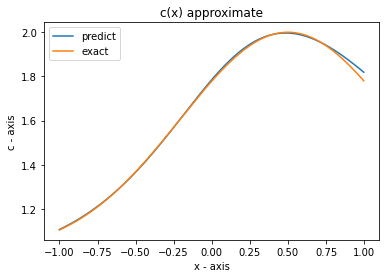

In [ ]:

import matplotlib.pyplot as plt
 
# line 1 points
x1 = x
y1 = []
for el in x:
    a = tf.reshape(tf.convert_to_tensor(el, dtype=tf.float32), [1])
    y1.append(PDEmodel(a)[0][0])
# plotting the line 1 points
plt.plot(x1, y1, label = "predict")
 
# line 2 points
x2 = x
y2 = []
for el in x:
    y2.append(c_exact(el))
# plotting the line 2 points
plt.plot(x2, y2, label = "exact")
 
# naming the x axis
plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('c - axis')
# giving a title to my graph
plt.title('c(x) approximate')
 
# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.show()